# Sheet 5

In [ ]:
import os
import pandas as pd

## 2 Logistic regression: an LLM lie detector

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use `add_dataset` multiple times on the same data manager if you want to combine datasets.

In [ ]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

In [ ]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

## 3 Log-sum-exp and soft(arg)max
### (b)

C:\Users\piecu\AppData\Local\Temp\ipykernel_3464\2429080611.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


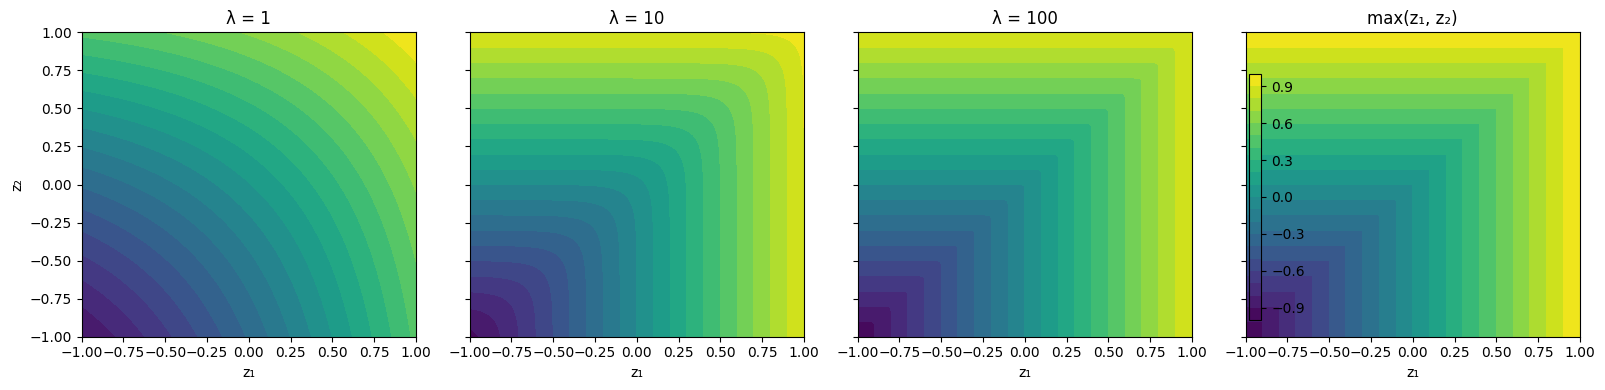

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def lse(z1, z2, lam):
    return (1/lam) * np.log(np.exp(lam*z1) + np.exp(lam*z2))

z = np.linspace(-1, 1, 400)
Z1, Z2 = np.meshgrid(z, z)
lams = [1, 10, 100]

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

for ax, lam in zip(axes[:3], lams):
    cs = ax.contourf(Z1, Z2, lse(Z1, Z2, lam), levels=20)
    ax.set_title(f"λ = {lam}")
    ax.set_xlabel("z₁")
axes[0].set_ylabel("z₂")

cs = axes[3].contourf(Z1, Z2, np.maximum(Z1, Z2), levels=20)
axes[3].set_title("max(z₁, z₂)")
axes[3].set_xlabel("z₁")

fig.colorbar(cs, ax=axes, shrink=0.8)
plt.tight_layout()
plt.show()


### Discussion of the plots of lse

The plots nicely show how the log-sum-exp function increasingly behaves like the max function as λ grows.

- **λ = 1**  
  The contour lines are round and smooth.  
  The function behaves more like a *soft average* of \(z_1\) and \(z_2\) than like a maximum.  
  Differences between \(z_1\) and \(z_2\) are heavily “smoothed out”.

- **λ = 10**  
  The contours start to take on a clearly bent, square-like shape:  
  - In regions where \(z_1 > z_2\), the lines are almost horizontal → the value is mainly determined by \(z_1\).  
  - In regions where \(z_2 > z_1\), they are almost vertical → the value is mainly determined by \(z_2\).  
  Only in a narrow band around the diagonal \(z_1 = z_2\) is the transition still smooth.

- **λ = 100**  
  The behavior is now very close to max(z_1, z_2):  
  - Away from the diagonal, the surface is almost flat in the “non-max” direction.  
  - Along \(z_1 = z_2\), there is only a very thin, smooth transition zone.  
  Log-sum-exp is practically a smoothed version of the max function here.

As λ increases, its contours and overall shape converge to those of the max, while for any finite λ it remains smooth everywhere.


### (c)

C:\Users\piecu\AppData\Local\Temp\ipykernel_3464\2390818294.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


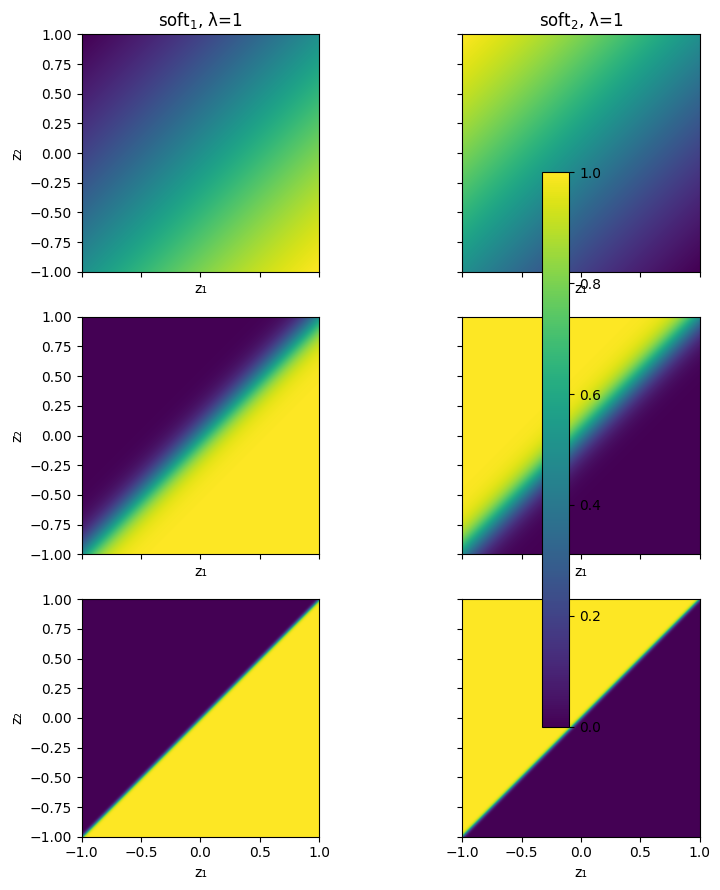

C:\Users\piecu\AppData\Local\Temp\ipykernel_3464\2390818294.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


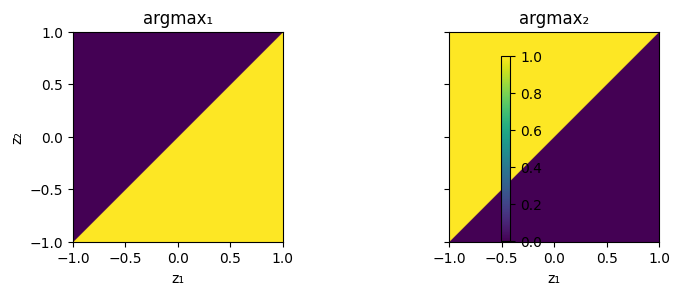

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Soft(arg)max für 2D-Vektor (z1, z2)
def softargmax_2d(z1, z2, lam):
    e1 = np.exp(lam * z1)
    e2 = np.exp(lam * z2)
    s = e1 + e2
    return e1 / s, e2 / s     # zwei Komponenten

# Gitter
z = np.linspace(-1, 1, 400)
Z1, Z2 = np.meshgrid(z, z)
lams = [1, 10, 100]

# (1) Soft(arg)max-Komponenten als Bilder
fig, axes = plt.subplots(len(lams), 2, figsize=(8, 9), sharex=True, sharey=True)

for i, lam in enumerate(lams):
    s1, s2 = softargmax_2d(Z1, Z2, lam)
    for j, (S, title) in enumerate(zip((s1, s2), (r"soft$_1$", r"soft$_2$"))):
        im = axes[i, j].imshow(
            S, origin="lower", extent=[-1, 1, -1, 1], aspect="equal"
        )
        if i == 0:
            axes[i, j].set_title(f"{title}, λ={lam}")
        axes[i, j].set_xlabel("z₁")
    axes[i, 0].set_ylabel("z₂")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()

# (2) Argmax als One-Hot-Vektoren
onehot1 = (Z1 > Z2).astype(float)
onehot2 = 1.0 - onehot1

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

for ax, H, title in zip(axes, (onehot1, onehot2), ("argmax₁", "argmax₂")):
    im = ax.imshow(H, origin="lower", extent=[-1, 1, -1, 1], aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("z₁")
axes[0].set_ylabel("z₂")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


### Interpretation of the soft(arg)max vs. argmax plots

- For small λ (e.g. λ = 1), the two soft(arg)max components are very smooth.  
  At each point \((z_1, z_2)\), both components lie between 0 and 1 and change gradually across the plane.  

- As λ increases (e.g. λ = 10, 100), the transition between “component 1 active” and “component 2 active” becomes much sharper.  
  The soft(arg)max outputs are close to \((1, 0)\) or \((0, 1)\) almost everywhere, except in a very thin band around the diagonal \(z_1 = z_2\), where the values are still mixed.

- The one-hot argmax plots show the corresponding hard decision:  
  - For \(z_1 > z_2\), the output is exactly \((1, 0)\).  
  - For \(z_2 > z_1\), the output is exactly \((0, 1)\).  
  There is a discontinuous jump along the diagonal \(z_1 = z_2\).

These plots illustrate that soft(arg)max is a relaxation of the argmax one-hot.  
For small λ it behaves softly and expresses uncertainty, for large λ it increasingly approximates the hard argmax decision.


## 4 Linear regions of MLPs